**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/01/2023 <br>

This analysis pretends to do an Exploratory Data Analysis of a dateset related to cancellations of travel packages.

Packages are a type of travel product that include flight tickets and hotel reservations.

### Summary 

1. Setup
<br></br>
2. Load data
<br></br>
3. Data cleaning and preprocessing
<br></br>
4. Analysis  
   1. Categorical features
   2. Date features
   3. Numerical features
<br></br>
5. Statistical ...


### Setup

In [1]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import src.utils as utils
from GoogleUtils import GoogleUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gutils = GoogleUtils()

### Load data

In [3]:
root = os.getcwd()

In [4]:
# to query from Google BigQuery

query = utils.read_file(f'{root}/src/queries/package_cancellation_data.sql')
df_cancel = gutils.read_from_bq(query)

# save locally

df_cancel.to_csv(f'{root}/src/data/cancellation_data.csv')

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [4]:
# to read local file

df_cancel = pd.read_csv(f'{root}/src/data/cancellation_data.csv')

In [5]:
df_cancel.head()

,Unnamed: 0,operation_order_id,operation_id,order_id,order_date,origin_city,order_origin_city,origin_state,origin_country,destination_type,...,first_valid_date,last_valid_date,first_possible_wish_date,first_wish_date,second_wish_date,third_wish_date,operation_status_id,operation_status_name,last_update_status_date,qty_status_changes
0,0,2607933697664803908,NaN,4754933939668799718,2020-01-31,Vitória,Vitória,Espírito Santo,Brasil,Nacional,...,2020-05-02,2020-11-30,NaN,2020-06-01,2020-06-01,2020-06-16,NaN,NaN,2020-03-17,3
1,1,3979962259074169557,6.307417e+18,6705513221332387204,2020-04-17,São Paulo,São Paulo,São Paulo,Brasil,Internacional,...,2021-03-01,2022-11-30,NaN,2022-05-15,2022-05-21,2022-06-26,7.0,"Finalizado, voucher emitido",2022-04-09,3
2,2,-7767481949674917927,NaN,1948500891665298452,2020-04-21,São Paulo,São Paulo,São Paulo,Brasil,Internacional,...,2021-03-01,2022-11-30,NaN,2021-10-09,2021-10-23,2021-11-06,NaN,NaN,2021-06-07,4
3,3,-5483619431292569576,4.122396e+18,6764749084123917124,2020-04-22,São Paulo,São Paulo,São Paulo,Brasil,Internacional,...,2021-03-01,2022-11-30,NaN,2022-08-16,2022-08-22,2022-09-01,14.0,Cancelada,2022-05-27,2
4,4,-3621452181715349751,4.101968e+18,6561632271208773198,2020-06-16,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,Brasil,Internacional,...,2021-03-01,2023-11-30,NaN,2022-11-08,2022-11-19,2022-11-25,14.0,Cancelada,2022-10-21,3


### Data Cleaning

We have a lot of null values:

In [6]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286564 entries, 0 to 286563
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                286564 non-null  int64  
 1   operation_order_id        286564 non-null  int64  
 2   operation_id              146843 non-null  float64
 3   order_id                  286564 non-null  int64  
 4   order_date                286564 non-null  object 
 5   origin_city               286564 non-null  object 
 6   order_origin_city         286564 non-null  object 
 7   origin_state              286564 non-null  object 
 8   origin_country            286564 non-null  object 
 9   destination_type          286564 non-null  object 
 10  destination_city          286564 non-null  object 
 11  destination_state         286093 non-null  object 
 12  destination_country       286564 non-null  object 
 13  qty_people                286564 non-null  i

- `first_possible_wish_date` is completely empty, so we'll remove the column.


- The feature `operation_id` indicates if the order started the process of being operated before the cancellation and the features `operation_status_id` and `operation_status_name` indicates the status of the operation process. The first feature we'll convert to boolean because we want to analyze if the client cancelled the order after the operation process started, and if a order was cancelled before the start of the operation, this information doesn't exists.


- The column `accommodation_type` has some missing data, we're going to look further on it before deciding if it will me removed or filled up.


- `destination_state` has few missing values, we can just drop those rows.



- `origin_city` and `origin_state` miss more than half of the data, but `order_origin_city` has the same purpose of `origin_city`. So, we'll see if it's possible to consider the `order_origin_city` valid and if we can use it to try to fill up the missing data of `origin_state`. 
- We can drop the `origin_country` column because this product is offer only to Brazil.
- The feature `filled_form` is related to the client inform the desired dates to travel, so is enough if this information is boolean too. `first_form_fill_date` and `last_form_fill_date` are related to the first and last date in which the client filled up the form, we'll use these features only to verify if the process of filling up the form and the cancellation are close events.


- The columns `first_wish_date`, `second_wish_date` and `third_wish_date` are the wished dates to travel informed by half of the clients, at a first moment we'll not be concern about these information.


Next we'll proceed to execute these modifications.

In [9]:
((df_cancel.isna().sum()/df_cancel.shape[0])*100).sort_values(ascending=False)

first_possible_wish_date    100.000000
operation_id                 48.757346
operation_status_name        48.757346
operation_status_id          48.757346
accommodation_type            8.592845
destination_state             0.164361
third_wish_date               0.000698
second_wish_date              0.000698
first_wish_date               0.000698
Unnamed: 0                    0.000000
filled_form                   0.000000
last_update_status_date       0.000000
last_valid_date               0.000000
first_valid_date              0.000000
last_form_fill_date           0.000000
first_form_fill_date          0.000000
qty_dailies                   0.000000
operation_order_id            0.000000
qty_people                    0.000000
destination_country           0.000000
destination_city              0.000000
destination_type              0.000000
origin_country                0.000000
origin_state                  0.000000
order_origin_city             0.000000
origin_city              

Converting columns to boolean:

In [10]:
df = utils.convert_to_boolean(df_cancel, 'operation_id')
df = utils.convert_to_boolean(df, 'filled_form')

Looking at order_origin_city:

ERRADO

There's a lot of inconsistencies between the two cities columns, so we'll consider only the common information to fill up the state column.

In [13]:
df[['origin_city', 'order_origin_city']].loc[df[['origin_city', 'order_origin_city']].origin_city != df[['origin_city', 'order_origin_city']].order_origin_city].drop_duplicates()

,origin_city,order_origin_city
121854,São Paulo,Cuiabá
206521,Rio de Janeiro,São Paulo
206559,Rio de Janeiro,Su00e3o Paulo
227182,Porto Alegre,São Paulo
267928,São Paulo,Sao Paulo


In [14]:
city_state = df[['origin_city', 'order_origin_city', 'origin_state']].drop_duplicates().dropna(how='any')
city_state = city_state.loc[city_state.order_origin_city == city_state.origin_city]
city_state_dict = {city: city_state.loc[city_state.order_origin_city == city].origin_state.values[0] for city in city_state.order_origin_city.values}

In [15]:
city_state_dict

{'Vitória': 'Espírito Santo',
 'São Paulo': 'São Paulo',
 'Rio de Janeiro': 'Rio de Janeiro',
 'Manaus': 'Amazonas',
 'Florianópolis': 'Santa Catarina',
 'Belo Horizonte': 'Minas Gerais',
 'Curitiba': 'Paraná',
 'Salvador': 'Bahia',
 'Fortaleza': 'Ceará',
 'Natal': 'Rio Grande do Norte',
 'Brasília': 'Distrito Federal',
 'Porto Alegre': 'Rio Grande do Sul',
 'Belém': 'Pará',
 'Recife': 'Pernambuco',
 'Campo Grande': 'Mato Grosso do Sul',
 'Maceió': 'Alagoas',
 'Goiânia': 'Goiás',
 'Palmas': 'Tocantins',
 'Cuiabá': 'Mato Grosso',
 'Macapá': 'Amapá',
 'João Pessoa': 'Paraíba',
 'Campinas': 'São Paulo',
 'Aracaju': 'Sergipe',
 'Foz do Iguaçu': 'Paraná',
 'Porto Velho': 'Rondônia',
 'Porto Seguro': 'Bahia',
 'Vitoria da Conquista': 'Bahia',
 'Ribeirão Preto': 'São Paulo',
 'Teresina': 'Piauí',
 'São Luís': 'Maranhão',
 'Guarulhos': 'São Paulo',
 'Rio Branco': 'Acre',
 'Boa Vista': 'Roraima'}

In [16]:
df.loc[df.origin_state.isna(), 'origin_state'] = df['order_origin_city'].map(city_state_dict)

We were able to fill up all the missing state information:

In [17]:
(df.origin_state.isna().sum()/df.shape[0])*100

0.0

Drop columns containing:
- unique identifiers
- information about origin country
- wish dates
- form filling date
- duplicate information

In [15]:
df = df.drop(['operation_id', 'order_id', 'origin_country', 'first_possible_wish_date', 'first_form_fill_date', 'last_form_fill_date', 'origin_city', 'first_wish_date', 'second_wish_date', 'third_wish_date', 'operation_status_id', 'operation_status_name'], axis=1)

Filling up the operation_status_name column:

In [16]:
df.loc[df.operation_status_name.isna(), 'operation_status_name'] = 'not started'

Looking at accommodation_type:

It's possible to notice that the column has the information of type varying even for the same room type. For instance, `Apartamento duplo` and `Apartamento duplo casal`. So we'll try to extract the main information of the column (individual, duplo, triplo, etc). In the cases where there's more than one option, we'll attribute a new type `multiple`. We'll attribute `not informed` for missing data.

In [17]:
df.loc[~df.accommodation_type.isna()].accommodation_type

0                                        Apartamento duplo.
1                                        Apartamento duplo.
2                                        Apartamento Duplo.
3                                        Apartamento duplo.
4                                        Apartamento duplo.
                                ...                        
286559    Quarto duplo ou triplo,de acordo com a opção e...
286560    Quarto individual, duplo ou triplo, de acordo ...
286561    Quarto duplo ou triplo, de acordo com a opção ...
286562    Quarto duplo ou triplo, de acordo com a opção ...
286563    Quarto duplo ou triplo,de acordo com a opção e...
Name: accommodation_type, Length: 261940, dtype: object

In [18]:
df.loc[df.accommodation_type.isna(), 'accommodation_type'] = 'not informed'

In [19]:
df['accommodation_type'] = df.accommodation_type.str.lower()
df.loc[df.accommodation_type.str.contains(','), 'accommodation_type'] = 'multiple'
df.loc[df.accommodation_type.str.contains('individual'), 'accommodation_type'] = 'individual'
df.loc[df.accommodation_type.str.contains('dupl'), 'accommodation_type'] = 'duplo'
df.loc[df.accommodation_type.str.contains('tripl'), 'accommodation_type'] = 'triplo'

Now we can just drop the few rows with missing value:

In [20]:
df = df.dropna(how='any')

Now we're going to change the dtype of some columns:

In [21]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['first_valid_date'] = pd.to_datetime(df['first_valid_date'])
df['last_valid_date'] = pd.to_datetime(df['last_valid_date'])
df['last_update_status_date'] = pd.to_datetime(df['last_update_status_date'])

df['qty_people'] = df['qty_people'].astype(int)
df['qty_dailies'] = df['qty_dailies'].astype(int)

### Analysis

#### Categorical

Let's start analyzing the data taking a look into the categorical data.

In [22]:
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette("flare"))

In [23]:
categorical_features = df.select_dtypes(include=['object_']).columns
categorical_features

Index(['order_origin_city', 'origin_state', 'destination_type',
       'destination_city', 'destination_state', 'destination_country',
       'accommodation_type', 'filled_form', 'operation_status_name'],
      dtype='object')

##### Origins

In [24]:
origin_state = df.groupby('origin_state').count().order_date.reset_index()
origin_state = origin_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
origin_state['percent'] = origin_state.volume/origin_state.volume.sum()

Most of the cancelled orders are with origin in the states of São Paulo, Rio de Janeiro, Minas Gerais and Distrito Federal.

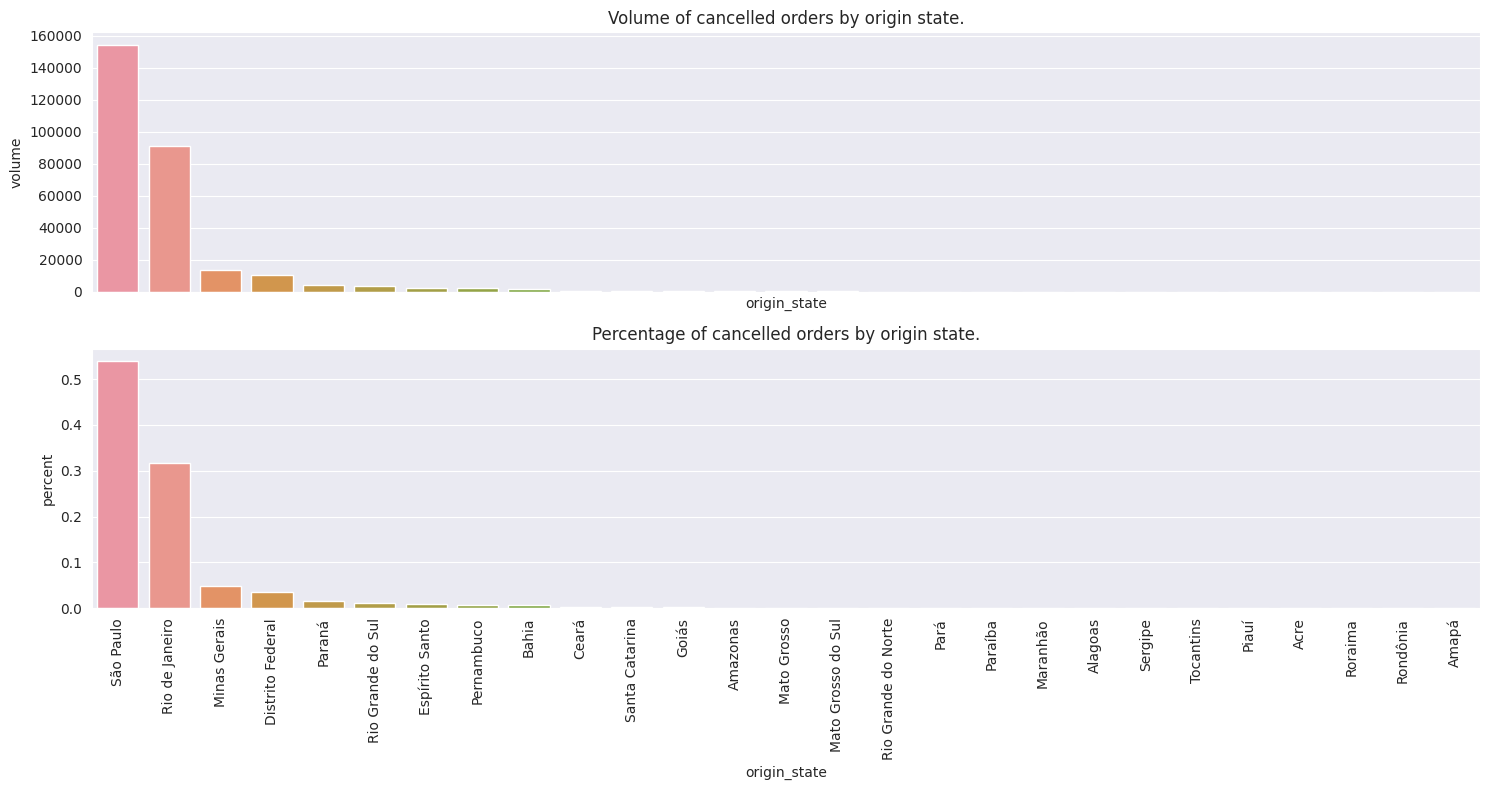

In [25]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_state, x='origin_state', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(origin_state, x='origin_state', y='percent', ax=ax[1]) #, palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin state.');
ax[1].set_title('Percentage of cancelled orders by origin state.');
plt.tight_layout()

In [26]:
origin_city = df.groupby('order_origin_city').count().order_date.reset_index()
origin_city = origin_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
origin_city['percent'] = origin_city.volume/origin_city.volume.sum()

We can verify that the 5 top origin cities are São Paulo, Rio de Janeiro, Belo Horizonte, Brasília and Curitiba. They represent almost 90% of the origins in this dataset.

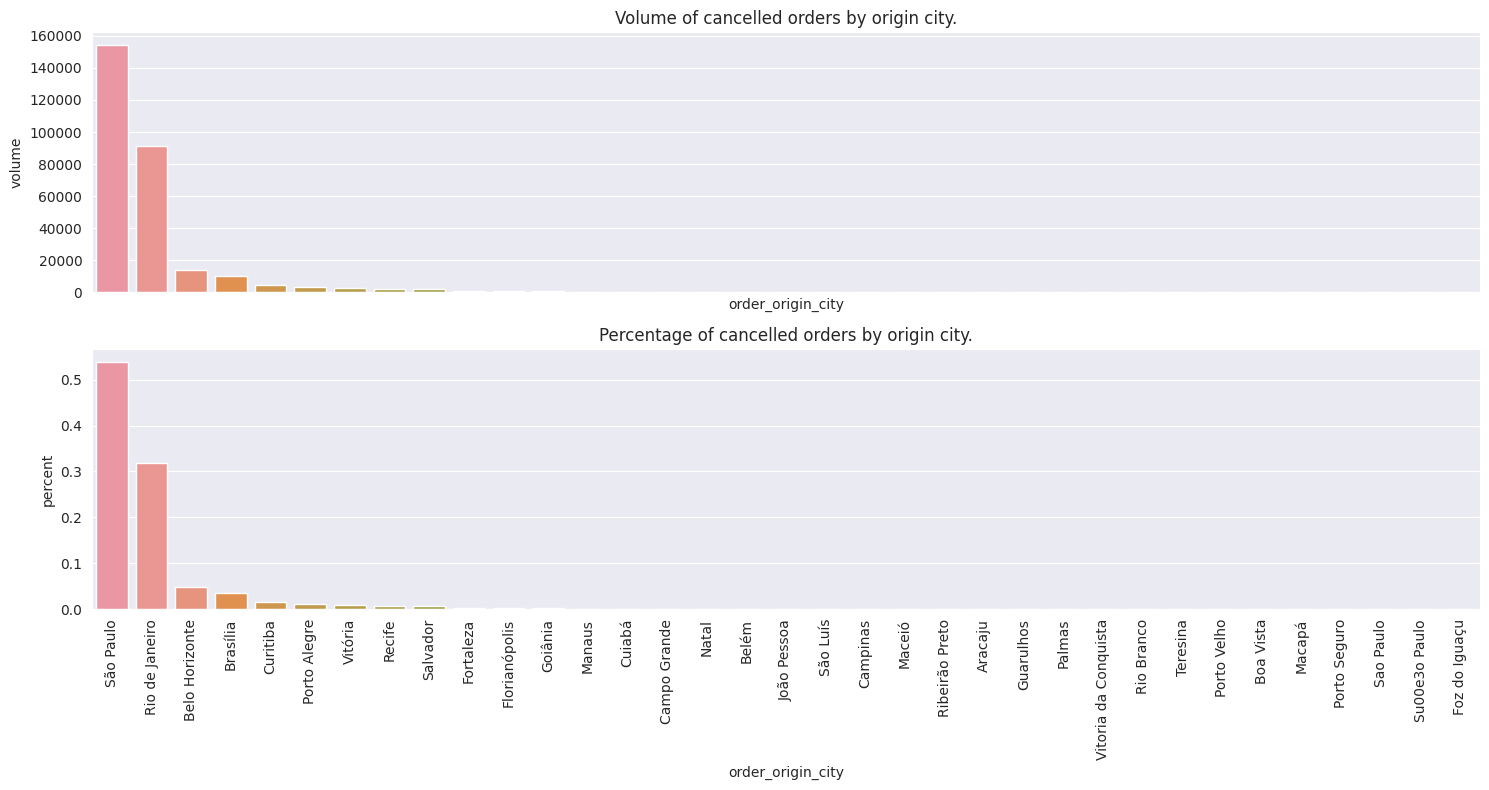

In [27]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_city, x='order_origin_city', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(origin_city, x='order_origin_city', y='percent', ax=ax[1]) #, palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin city.');
ax[1].set_title('Percentage of cancelled orders by origin city.');
plt.tight_layout()

##### Destinations

In [28]:
destination_type = df.groupby('destination_type').count().order_date.reset_index()
destination_type = destination_type.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_type['percent'] = destination_type['volume']/df.shape[0]

More than 50% of the cancellations have national destination (Brazil).

Text(0.5, 1.0, 'Percentage of cancellations by destinations type.')

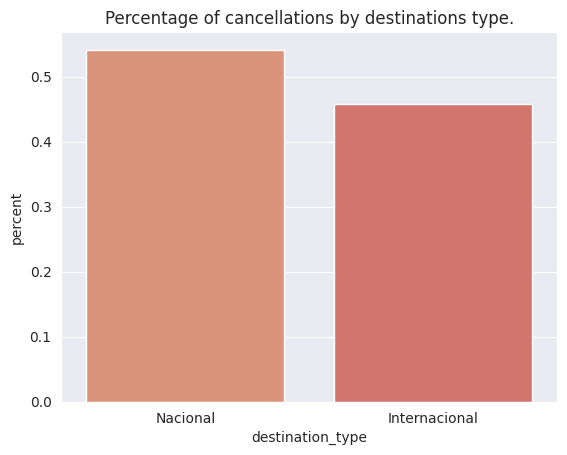

In [29]:
sns.barplot(destination_type, x='destination_type', y='percent')
plt.title('Percentage of cancellations by destinations type.')

In [30]:
destination_state = df.groupby('destination_state').count().order_date.reset_index()
destination_state = destination_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_state['percent'] = destination_state.volume/destination_state.volume.sum()

We limited the plot to the top 35 destination states to keep the graph interpretable. It's possible to verify that in the top 10 destination state we have only two that are international: Flórida and Quintana Roo.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


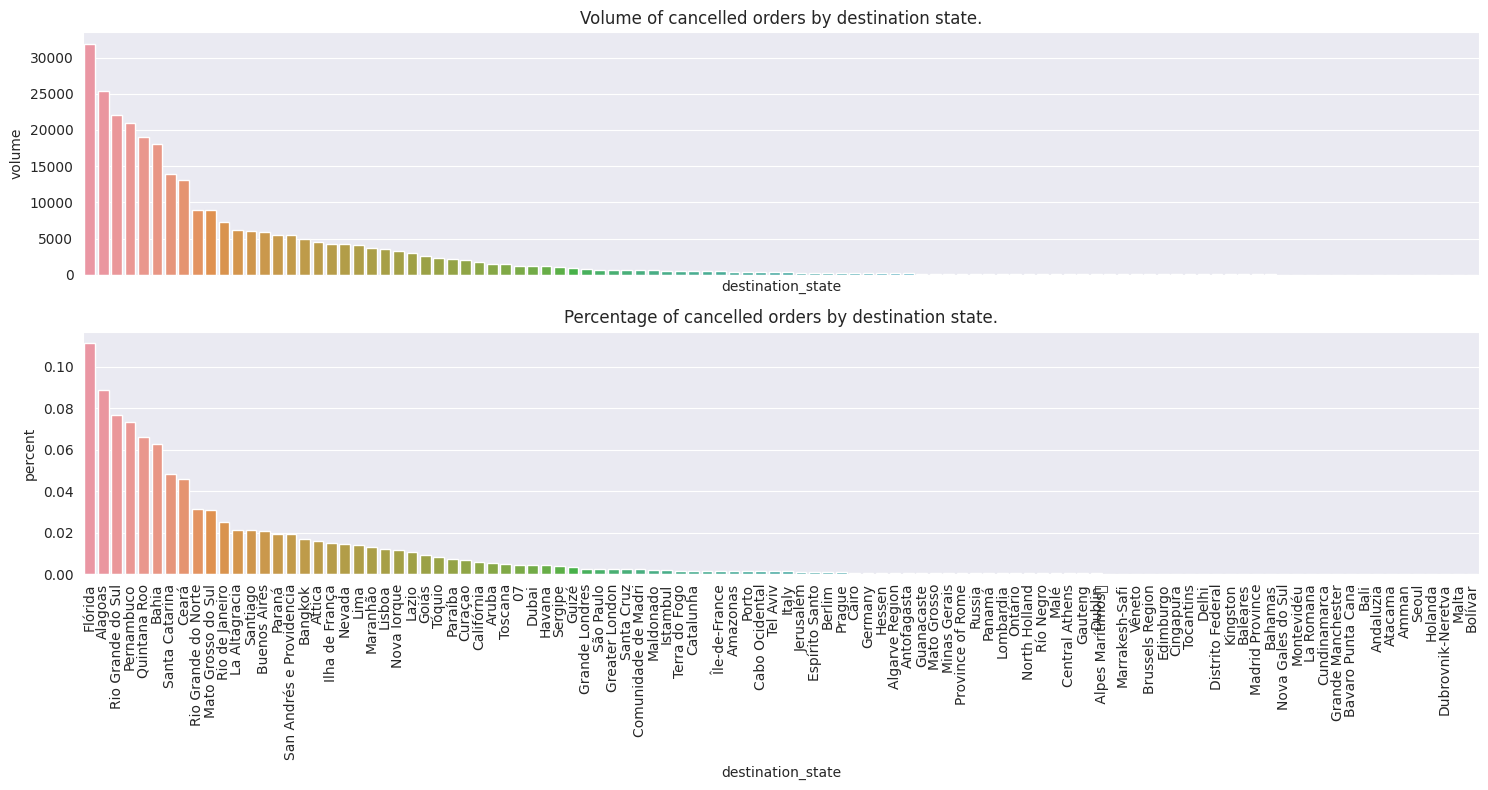

In [54]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_state.loc[:20], x='destination_state', y='volume', ax=ax[0] ) #, palette=sns.color_palette());
sns.barplot(destination_state.loc[:20], x='destination_state', y='percent', ax=ax[1]) #, palette=sns.color_palette());

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination state.');
ax[1].set_title('Percentage of cancelled orders by destination state.');
plt.tight_layout()

In [32]:
destination_city = df.groupby('destination_city').count().order_date.reset_index()
destination_city = destination_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_city['percent'] = destination_city.volume/destination_city.volume.sum()

Among the top cities within cancellations, we have the to related to the international states mentioned before: Orlando (Florida) and Cancún (Quintana Roo).And a lot of Brazilian cities.

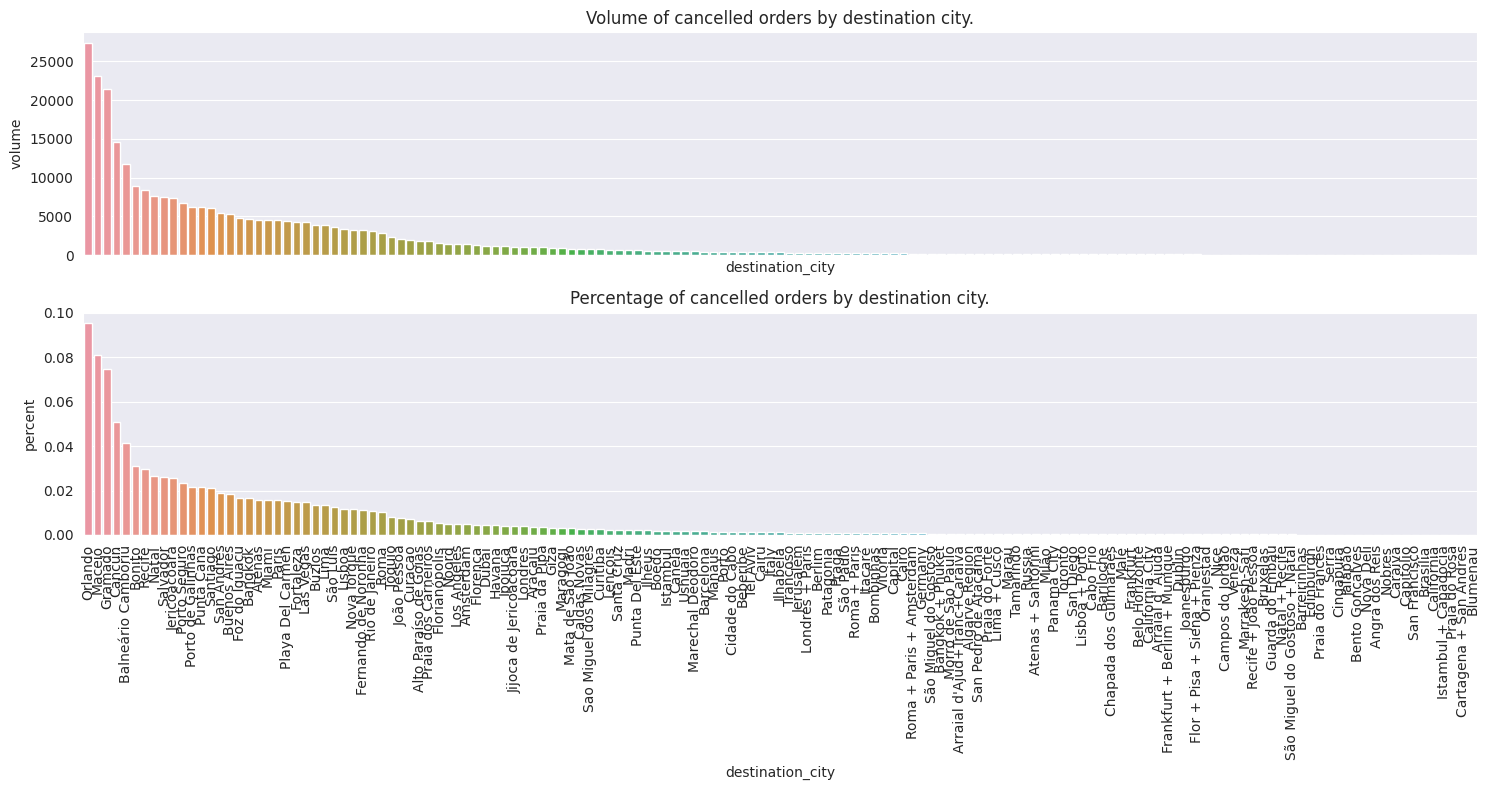

In [33]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_city.loc[:30], x='destination_city', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(destination_city.loc[:30], x='destination_city', y='percent', ax=ax[1]) #, palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination city.');
ax[1].set_title('Percentage of cancelled orders by destination city.');
plt.tight_layout()

TO DO **maybe try to plot a Sankey graph**

##### Accomodations

In [34]:
accommod = df.groupby('accommodation_type').count().order_date.reset_index()
accommod = accommod.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
accommod['percent'] = accommod.volume/accommod.volume.sum()

Only 4 accommodation types correspond to 99% of the cases, so we'll consider only this 4 categories.

In [35]:
accommod.cumsum()[:10]

,accommodation_type,volume,percent
8,multiple,127650,0.445450
5,multipleduplo,248571,0.867419
9,multipleduplonot informed,273195,0.953347
7,multipleduplonot informedindividual,284703,0.993506
12,multipleduplonot informedindividualstandard.,285834,0.997453
13,multipleduplonot informedindividualstandard.su...,286274,0.998988
11,multipleduplonot informedindividualstandard.su...,286480,0.999707
6,multipleduplonot informedindividualstandard.su...,286514,0.999826
0,multipleduplonot informedindividualstandard.su...,286537,0.999906
3,multipleduplonot informedindividualstandard.su...,286557,0.999976


Text(0.5, 1.0, 'Percentage of the top 4 destination types.')

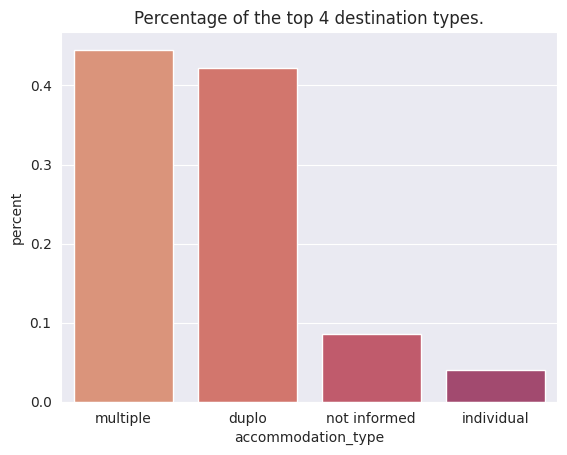

In [36]:
sns.barplot(accommod[:4], x='accommodation_type', y='percent')
plt.title('Percentage of the top 4 destination types.')

In [37]:
df = df.loc[df['accommodation_type'].isin(accommod[:4]['accommodation_type'])]

##### Filled Forms

In [38]:
forms = df.groupby('filled_form').count().order_date.reset_index()
forms = forms.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
forms['percent'] = forms.volume/forms.volume.sum()

In all cases the form was filled up, so we can discard this feature.

In [39]:
forms.cumsum()

,filled_form,volume,percent
0,1,284703,1.0


In [40]:
df = df.drop('filled_form', axis=1)

##### Status

In [41]:
status = df.groupby('operation_status_name').count().order_date.reset_index()
status = status.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
status['percent'] = status.volume/status.volume.sum()

For the operation_status_name, seven categories correspond to 99% of the samples. We'll restrict the dataset to these cases.

An interesting insight is that almost 50% of the cases was cancelled before starting the operation.

In [42]:
status.cumsum()[:10]

,operation_status_name,volume,percent
12,not started,138829,0.487627
4,not startedCancelada,247305,0.868642
1,not startedCanceladaAtribuído,260768,0.915930
6,not startedCanceladaAtribuídoCotando aéreo,272504,0.957152
10,not startedCanceladaAtribuídoCotando aéreoFina...,280948,0.986811
8,not startedCanceladaAtribuídoCotando aéreoFina...,282461,0.992125
5,not startedCanceladaAtribuídoCotando aéreoFina...,283692,0.996449
2,not startedCanceladaAtribuídoCotando aéreoFina...,284202,0.998240
7,not startedCanceladaAtribuídoCotando aéreoFina...,284480,0.999217
3,not startedCanceladaAtribuídoCotando aéreoFina...,284692,0.999961


In [43]:
df = df.loc[df['operation_status_name'].isin(status[:7]['operation_status_name'])]

#### Dates

In [44]:
not_categorical = np.setdiff1d(df.columns, categorical_features)
not_categorical

array(['first_valid_date', 'last_update_status_date', 'last_valid_date',
       'order_date', 'qty_dailies', 'qty_people', 'qty_status_changes'],
      dtype=object)

In [55]:
df.last_update_status_date.sort_values()

134354   2019-01-02
72039    2019-01-04
190731   2019-01-04
242822   2019-01-04
144082   2019-01-07
            ...    
79450    2023-02-11
115726   2023-02-11
5366     2023-02-11
83601    2023-02-11
95057    2023-02-11
Name: last_update_status_date, Length: 283692, dtype: datetime64[ns]

In [46]:
df_dates = utils.create_date_columns(df, ['first_valid_date', 'last_update_status_date', 'last_valid_date', 'order_date'])

Let's compute the difference between the order_date and the last_update_status_date_brt to verify the difference between the purchases and it's cancellations.

In [47]:
df_dates['time_to_cancel'] = (df['last_update_status_date'] - df['order_date'])
df_dates['time_to_cancel_days'] = df_dates['time_to_cancel'].astype('timedelta64[D]').astype(int)
df_dates['time_to_cancel_months'] = df_dates['time_to_cancel'].astype('timedelta64[M]').astype(int)

In [48]:
time_to_cancel_days = df_dates.groupby('time_to_cancel_days').count().order_date_year.reset_index()
time_to_cancel_days = time_to_cancel_days.rename(columns={'order_date_year': 'volume'}).sort_values('volume', ascending=False)
time_to_cancel_days['percent'] = time_to_cancel_days.volume/time_to_cancel_days.volume.sum()

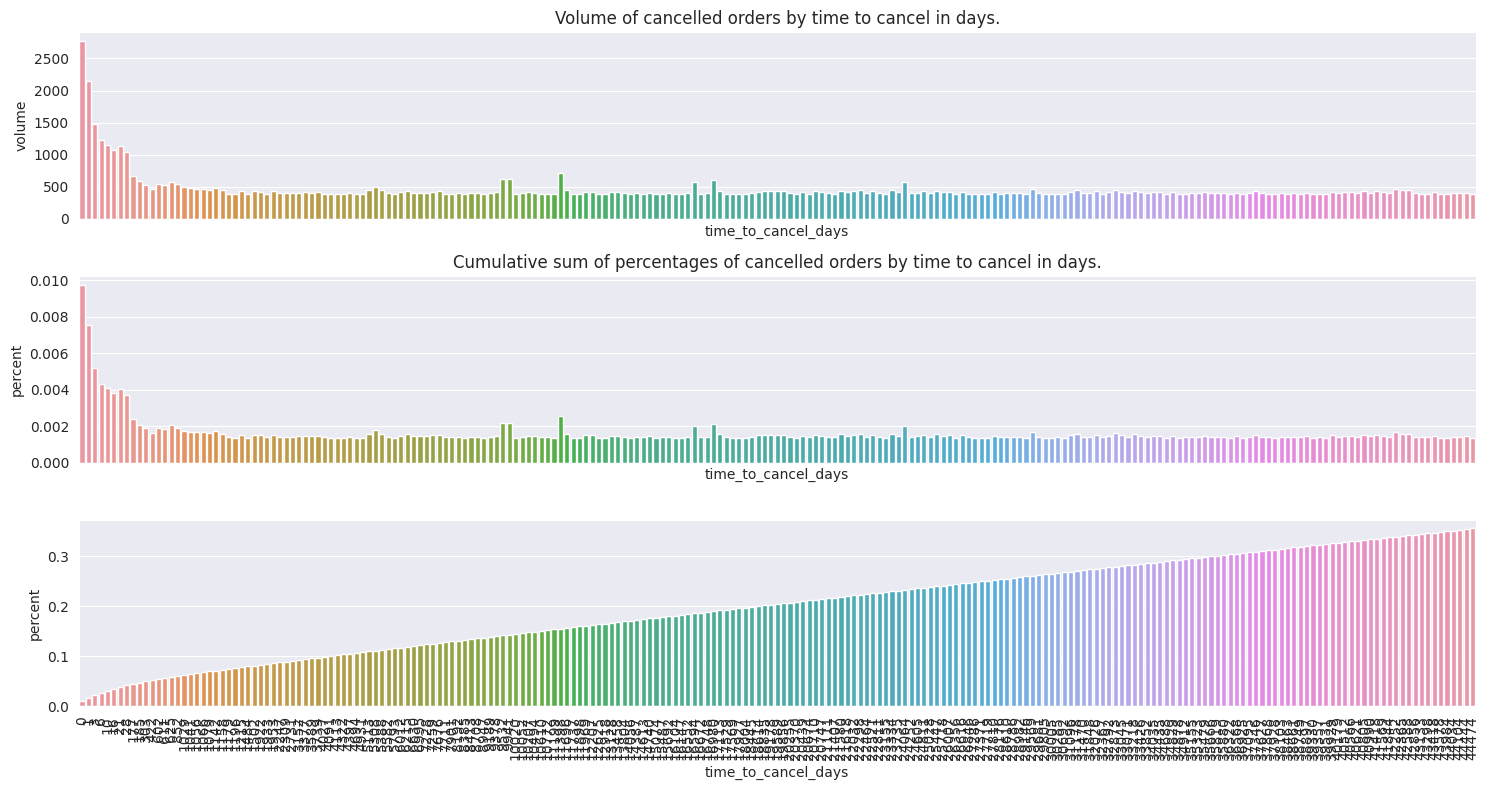

In [49]:
fig, ax = plt.subplots(3, sharex=True, figsize=(15,8))

sns.barplot(time_to_cancel_days.loc[:30], x='time_to_cancel_days', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(time_to_cancel_days.loc[:30], x='time_to_cancel_days', y='percent', ax=ax[1]) #, palette=sns.color_palette())
sns.barplot(time_to_cancel_days.loc[:30].cumsum(), x='time_to_cancel_days', y='percent', ax=ax[2])

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by time to cancel in days.');
ax[1].set_title('Percentage of cancelled orders by time to cancel in days.');
ax[1].set_title('Cumulative sum of percentages of cancelled orders by time to cancel in days.');
plt.tight_layout()

In [50]:
time_to_cancel_months = df_dates.groupby('time_to_cancel_months').count().order_date_year.reset_index()
time_to_cancel_months = time_to_cancel_months.rename(columns={'order_date_year': 'volume'}).sort_values('volume', ascending=False)
time_to_cancel_months['percent'] = time_to_cancel_months.volume/time_to_cancel_months.volume.sum()

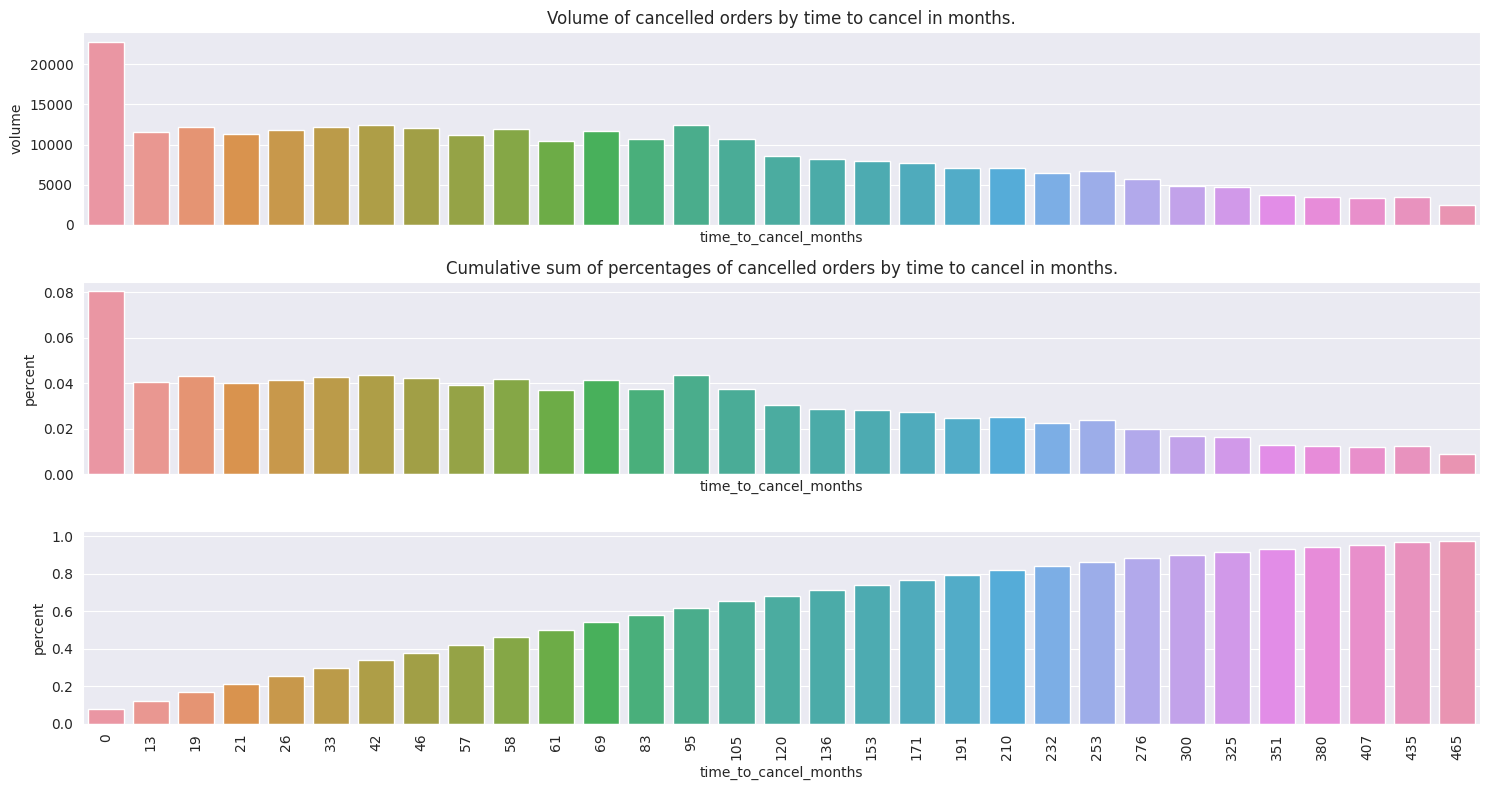

In [51]:
fig, ax = plt.subplots(3, sharex=True, figsize=(15,8))

sns.barplot(time_to_cancel_months.loc[:30], x='time_to_cancel_months', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(time_to_cancel_months.loc[:30], x='time_to_cancel_months', y='percent', ax=ax[1]) #, palette=sns.color_palette())
sns.barplot(time_to_cancel_months.loc[:30].cumsum(), x='time_to_cancel_months', y='percent', ax=ax[2])

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by time to cancel in months.');
ax[1].set_title('Percentage of cancelled orders by time to cancel in months.');
ax[1].set_title('Cumulative sum of percentages of cancelled orders by time to cancel in months.');
plt.tight_layout()

In [52]:
valid_date = df_dates.groupby('first_valid_date_month').count().order_date.reset_index()
valid_date = valid_date.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
valid_date['percent'] = valid_date.volume/valid_date.volume.sum()

AttributeError: 'DataFrame' object has no attribute 'order_date'

Just one month corresponds to 63% of the cases, and four months correspond to 94%. The increase from the fifth month is lower than 5%, so we'll not consider them.

In [ ]:
valid_date.cumsum()[:10]

In [ ]:
valid_date[:5]